# Explanation of this notebook

This notebook got three purposes:
1. Improve the estimated delivery date given to customers at the purchase moment
2. Predict wether a delivery is gonna be late
3. Use clustering (k-means) to sugest where and how many warehouses to construct

# <font color='blue'>Setup 1</font>: Load Libraries

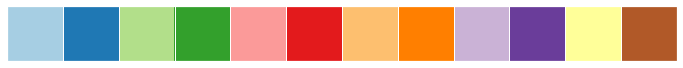

In [46]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data

In [47]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [48]:
# Reading the olist_orders table
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers = load_table('olist_sellers_dataset.csv')
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']
geo = load_table('olist_geolocation_dataset.csv')

In [49]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [50]:
order_items[order_items['order_id']=='8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [51]:
order_items.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [52]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [53]:
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']

In [54]:
order_items_filt.describe()

,freight_value,price,quantity,order_price
count,102425.000000,102425.000000,102425.000000,102425.000000
mean,20.111152,124.422006,1.150539,136.778317
std,15.884700,188.926084,0.563005,209.629971
min,0.000000,0.850000,1.000000,0.850000
25%,13.140000,40.000000,1.000000,45.900000
50%,16.320000,78.800000,1.000000,85.000000
75%,21.220000,139.000000,1.000000,149.900000
max,409.680000,6735.000000,21.000000,13440.000000


In [55]:
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

In [56]:
order_items_filt

,order_id,seller_id,shipping_limit_date,freight_value,quantity,order_price
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,13.29,1,58.90
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,19.93,1,239.90
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,17.87,1,199.00
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.79,1,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,18.14,1,199.90
...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,43.41,1,299.99
102421,fffcd46ef2263f404302a634eb57f7eb,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,36.53,1,350.00
102422,fffce4705a9662cd70adb13d4a31832d,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,16.95,1,99.90
102423,fffe18544ffabc95dfada21779c9644f,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,8.72,1,55.99


In [57]:
order_items_filt.describe()

,freight_value,quantity,order_price
count,102425.000000,102425.000000,102425.000000
mean,20.111152,1.150539,136.778317
std,15.884700,0.563005,209.629971
min,0.000000,1.000000,0.850000
25%,13.140000,1.000000,45.900000
50%,16.320000,1.000000,85.000000
75%,21.220000,1.000000,149.900000
max,409.680000,21.000000,13440.000000


# <font color='blue'>Setup 3</font>: Merge datasets

In [324]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']
customers_geo = customers_geo.groupby('customer_id')['customer_lat','customer_lon'].agg('mean').reset_index()

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']
sellers_geo = sellers_geo.groupby('seller_id')['seller_lat','seller_lon'].agg('mean').reset_index()

In [325]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 'order_purchase_timestamp',
                         'order_approved_at','order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date','order_price',
                         'quantity','freight_value','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In [326]:
orders_all.head()

,order_id,order_status,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086


In [327]:
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

In [328]:
delivered_orders

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103195,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-15 09:54:05,2017-03-17 15:08:01,2017-03-28 00:00:00,72.00,1.0,13.08,-23.178000,-45.883818,-22.961694,-46.523854
103196,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-12 13:10:37,2018-02-28 17:37:56,2018-03-02 00:00:00,174.90,1.0,20.10,-24.001500,-46.449864,-21.930548,-50.498348
103197,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-05 15:04:16,2017-09-21 11:24:17,2017-09-27 00:00:00,205.99,1.0,65.02,-17.898358,-39.373630,-23.553642,-46.452661
103198,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,a1043bafd471dff536d0c462352beb48,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-12 21:36:21,2018-01-25 23:32:54,2018-02-15 00:00:00,359.98,2.0,40.59,-22.562825,-42.694574,-20.940578,-45.827237


In [329]:
#Changing these columns to datetimes
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

# <font color='blue'>Part 1</font>: Descriptive analysis

In [330]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    
    print(num_missing)

In [331]:
count_missing_values(delivered_orders)

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  14      0.0001
order_delivered_carrier_date        2      0.0000
shipping_limit_date                 0      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_price                         0      0.0000
quantity                            0      0.0000
freight_value                       0      0.0000
customer_lat                      273      0.0027
customer_lon                      273      0.0027
seller_lat                        222      0.0022
seller_lon                        222      0.0022


##### Deleting all rows which have NaN values

In [332]:
delivered_orders = delivered_orders.dropna()

In [333]:
delivered_orders.head()

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086


When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. While the customer is given a `order_estimated_delivery_date`.

In [334]:
#Calculating difference between order_estimated_delivery_date and the actual order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [335]:
delivered_orders['delivery_difference'].describe()

count    99679.000000
mean        10.987490
std         10.209183
min       -189.000000
25%          6.000000
50%         12.000000
75%         16.000000
max        146.000000
Name: delivery_difference, dtype: float64

The product is recieved by the customer 10,98 days ahead of the estimated delivery day.

In [336]:
delivered_orders.describe(include='O')

,order_id,customer_id,seller_id
count,99679,99679,99679
unique,95979,95979,2963
top,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,6560211a19b47992c3666cc44a7e94c0
freq,8,8,1942


In [337]:
print("Number of orders delivered later than the estimated delivery data:",len(delivered_orders[delivered_orders['delivery_difference']<0]))

Number of orders delivered later than the estimated delivery data: 7944


Meaning ~8% of the orders was delivered later than the estimated delivery date.

In the olist_orders_dataset we have 95978 unique orders. I.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether we are to blame the sellers or the logistic firm for the orders delivered late. Therefor we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If Y > 0 the order was delivered on time. 
- If Y < 0 and X > 0 the logistic firm is the one to blame
- If Y < 0 and X >= Y then the seller is the one to blame
- If Y < 0 and X < 0 the both the seller and the logistic firm is to blame

In [338]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Removing outlier

In [339]:
delivered_orders = delivered_orders.drop(89664)

In [340]:
delivered_orders['shipping_difference'].describe()

count    99678.000000
mean         2.832551
std          3.747471
min       -117.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        175.000000
Name: shipping_difference, dtype: float64

A product is passed on to the logistic firm 2.8 days ahead on average.

In [341]:
delivered_orders[delivered_orders['delivery_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,1.0,8.96,-23.572939,-46.651115,-23.676570,-46.669897,-12,-12
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,c0563dd588b775f2e37747ef6ad6c92c,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-02-28 02:30:44,2018-03-21 22:03:54,2018-03-12,109.90,1.0,15.53,-22.879477,-43.440264,-23.622288,-46.536901,-10,1
36,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,955fee9216a65b617aa5c0531780ce60,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-02-22 15:15:34,2018-03-20 00:59:25,2018-03-20,78.00,1.0,28.95,-12.478669,-49.122905,-23.691013,-46.703810,-1,1
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,1.0,17.12,-21.874288,-51.844970,-27.231416,-49.657477,-8,-14
58,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,db4350fd57ae30082dec7acbaacc17f9,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-03-15 15:30:45,2018-04-03 13:28:46,2018-04-02,45.98,2.0,22.85,-10.971622,-37.067341,-23.580395,-46.591326,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103154,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,5b0cc932433fa5184b5b94bfe6bcc256,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-08 23:04:06,2018-08-21 00:03:26,2018-08-16,190.00,2.0,24.75,-23.662299,-46.421695,-21.757321,-48.829744,-6,-7
103155,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,620c87c171fb2a6dd6e8bb4dec959fc6,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-03-19 22:30:45,2018-04-05 19:59:49,2018-04-02,249.90,1.0,19.63,-23.568188,-46.594754,-22.540797,-43.201235,-4,5
103181,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,fa40cc5b934574b62717c68f3d678b6d,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-10-19 04:28:24,2017-11-21 17:06:59,2017-10-31,36.90,1.0,11.85,-21.772226,-48.180222,-23.472815,-46.600729,-22,1
103183,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,701938c450705b8ae65fc923b70f35c7,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-03-27 20:05:26,2018-04-11 00:48:31,2018-04-09,109.97,1.0,36.86,-22.951602,-47.001996,-20.818959,-49.377346,-3,4


In [342]:
def plot_late_order(df):
    
    X = [x for x in df.delivery_difference]
    X = np.array(X)
    Y = [y for y in df.shipping_difference]
    Y = np.array(Y)

    col = np.where((X<0) & (Y<0) & (Y<X),'red',
            np.where((X<0) & (Y<0) & (Y>=X),'yellow',
                np.where((X<0) & (Y>=0),'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Delivery difference')
    ax.set_ylabel('Shipping difference')
    ax.set_title('Orders')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

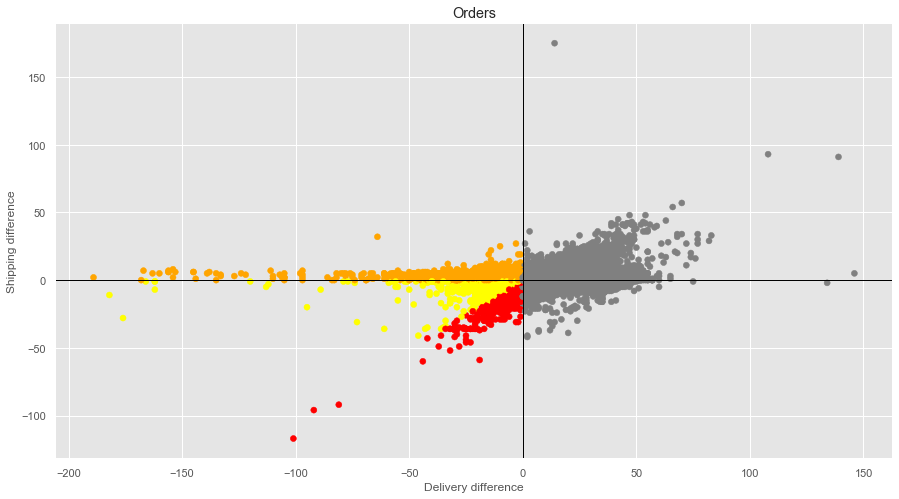

In [343]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

In [344]:
delivered_orders[delivered_orders['delivery_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,1.0,8.96,-23.572939,-46.651115,-23.676570,-46.669897,-12,-12
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,c0563dd588b775f2e37747ef6ad6c92c,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-02-28 02:30:44,2018-03-21 22:03:54,2018-03-12,109.90,1.0,15.53,-22.879477,-43.440264,-23.622288,-46.536901,-10,1
36,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,955fee9216a65b617aa5c0531780ce60,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-02-22 15:15:34,2018-03-20 00:59:25,2018-03-20,78.00,1.0,28.95,-12.478669,-49.122905,-23.691013,-46.703810,-1,1
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,1.0,17.12,-21.874288,-51.844970,-27.231416,-49.657477,-8,-14
58,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,db4350fd57ae30082dec7acbaacc17f9,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-03-15 15:30:45,2018-04-03 13:28:46,2018-04-02,45.98,2.0,22.85,-10.971622,-37.067341,-23.580395,-46.591326,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103154,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,5b0cc932433fa5184b5b94bfe6bcc256,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-08 23:04:06,2018-08-21 00:03:26,2018-08-16,190.00,2.0,24.75,-23.662299,-46.421695,-21.757321,-48.829744,-6,-7
103155,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,620c87c171fb2a6dd6e8bb4dec959fc6,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-03-19 22:30:45,2018-04-05 19:59:49,2018-04-02,249.90,1.0,19.63,-23.568188,-46.594754,-22.540797,-43.201235,-4,5
103181,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,fa40cc5b934574b62717c68f3d678b6d,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-10-19 04:28:24,2017-11-21 17:06:59,2017-10-31,36.90,1.0,11.85,-21.772226,-48.180222,-23.472815,-46.600729,-22,1
103183,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,701938c450705b8ae65fc923b70f35c7,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-03-27 20:05:26,2018-04-11 00:48:31,2018-04-09,109.97,1.0,36.86,-22.951602,-47.001996,-20.818959,-49.377346,-3,4


In [345]:
X = [x for x in delivered_orders.delivery_difference]
Y = [y for y in delivered_orders.shipping_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]>=0)]
yellow_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]>=X[i])]
red_points = [i for i, x in enumerate(X) if (X[i]<0) and (Y[i]<0) and (Y[i]<X[i])]

In [346]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 92.03 pct. of the orders was delivered on time
  5.78 pct. of the orders was delivered late because of the logistic firm
  1.34 pct. of the orders was delivered late because of the seller
  0.85 pct. of the orders was delivered late because of both the seller and logistic firm


# <font color='blue'>Part 2</font>: Prediction - Estimated delivery time

In [347]:
delivered_orders['actual'] = delivered_orders.order_delivered_customer_date - delivered_orders.order_purchase_timestamp
delivered_orders['actual'] = delivered_orders['actual'].dt.days

In [348]:
delivered_orders.actual.describe()

count    99678.000000
mean        12.021279
std          9.530233
min          0.000000
25%          6.000000
50%         10.000000
75%         15.000000
max        209.000000
Name: actual, dtype: float64

In [349]:
delivered_orders

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,quantity,freight_value,customer_lat,customer_lon,seller_lat,seller_lon,delivery_difference,shipping_difference,actual
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18,29.99,1.0,8.72,-23.576983,-46.587161,-23.680729,-46.444238,7,1,8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13,118.70,1.0,22.76,-12.177924,-44.660711,-19.807681,-43.980427,5,3,13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04,159.90,1.0,19.22,-16.745150,-48.514783,-21.363502,-48.229601,17,4,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15,45.00,1.0,27.20,-5.774190,-35.271143,-19.837682,-43.924053,12,1,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26,19.90,1.0,8.72,-23.676370,-46.514627,-23.543395,-46.262086,9,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103195,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-15 09:54:05,2017-03-17 15:08:01,2017-03-28,72.00,1.0,13.08,-23.178000,-45.883818,-22.961694,-46.523854,10,4,8
103196,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-12 13:10:37,2018-02-28 17:37:56,2018-03-02,174.90,1.0,20.10,-24.001500,-46.449864,-21.930548,-50.498348,1,4,22
103197,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-05 15:04:16,2017-09-21 11:24:17,2017-09-27,205.99,1.0,65.02,-17.898358,-39.373630,-23.553642,-46.452661,5,7,24
103198,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,a1043bafd471dff536d0c462352beb48,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-12 21:36:21,2018-01-25 23:32:54,2018-02-15,359.98,2.0,40.59,-22.562825,-42.694574,-20.940578,-45.827237,20,0,17


In [355]:
from sklearn.model_selection import train_test_split

features = ['order_price','quantity','freight_value','customer_lat',
           'customer_lon','seller_lat','seller_lon']
target = ['actual']

X = np.array(delivered_orders[features])
y = np.array(delivered_orders['actual'])
split_test_size = 0.30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state=42)

# <font color='blue'>2.2</font>: Establish baseline

In [360]:
baseline_preds = delivered_orders['delivery_difference'].values
X_baseline = baseline_preds[:69774]
Y_baseline = baseline_preds[69774:]

baseline_errors = abs(Y_baseline - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'days')

Average baseline error:  9.71 days


In [361]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [363]:
predictions = lr.predict(X_test)

errors = abs(predictions - y_test)

print('Average baseline error: ', round(np.mean(errors), 2), 'days')

Average baseline error:  5.99 days


In [364]:
mape = 100 * (errors/y_test)

accuracy = 100 - np.mean(mape)

print('Accuracy: ', round(accuracy, 2), '%')

Accuracy:  -inf %


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [365]:
errors

array([ 3.03411108,  6.07028649, 10.02920445, ...,  5.0560483 ,
        0.80539876,  2.88415838])

In [368]:
mape

array([  21.67222203,  101.17144149, 1002.92044508, ...,   84.26747164,
          7.32180692,   26.21962163])

# <font color='blue'>Part 3</font>: Prediction - Late delivery (yes or no)

# <font color='blue'>Part 4</font>: Clustering - Warehouse locations